In [3]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import boto3
from botocore.exceptions import ClientError
from IPython.display import Audio
import IPython
from scipy.io import wavfile
from pydub import AudioSegment
import soundfile as sf
from io import BytesIO
from pyAudioAnalysis import audioBasicIO, ShortTermFeatures, MidTermFeatures
import audiosegment

import librosa
import librosa.display
import PIL

import os

from src.feature_extraction import vector_merge, call_s3, audio_vectorize

In [4]:
s3_connection = boto3.resource('s3')
s3_client = boto3.client('s3')

In [5]:
bucket_name = 'jarednewstudy'

In [6]:
#using soundfile module
folder = 'audio_train/'
file_name = '6a1f682a.wav'
path = folder + file_name

response = s3_client.get_object(Bucket=bucket_name,
                                 Key=path,
                                )

data = BytesIO(response['Body'].read())
sound, samplerate = sf.read(data)
Audio(data=sound, rate=samplerate)

In [7]:
# using AudioSegment module
response = s3_client.get_object(Bucket=bucket_name,
                                 Key=path,
                                )
data = BytesIO(response['Body'].read())
seg = AudioSegment.from_wav(data)

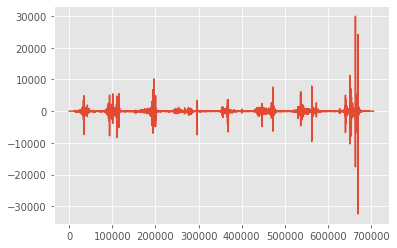

In [8]:
sample_array = seg.get_array_of_samples()
fig, ax = plt.subplots()

plt.plot(sample_array)

In [9]:
# using audiosegment module (wrapper for AudioSegment)

In [10]:
obj = s3_connection.Object(bucket_name, key=path)
result = obj.get()['Body'].read()
wrapper = BytesIO(result)
wav_ = wavfile.read(wrapper)
seg = audiosegment.from_numpy_array(wav_[1], wav_[0])

Text(0, 0.5, 'Frequency in Hz')

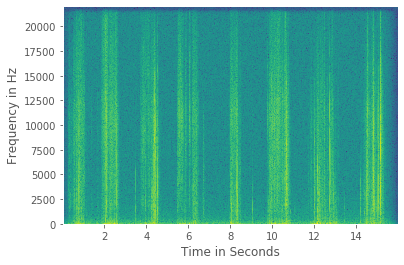

In [11]:
#...
freqs, times, amplitudes = seg.spectrogram(window_length_s=0.03, overlap=0.5)
amplitudes = 10 * np.log10(amplitudes + 1e-9)

# Plot
plt.pcolormesh(times, freqs, amplitudes)
plt.xlabel("Time in Seconds")
plt.ylabel("Frequency in Hz")



Text(0, 0.5, 'energy')

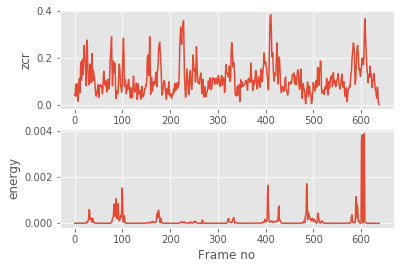

In [12]:
#short term feature extraction example

obj = s3_connection.Object(bucket_name, key=path)
result = obj.get()['Body'].read()
wrapper = BytesIO(result)
wav_ = wavfile.read(wrapper)


Fs, x = wav_[0], wav_[1]
F, f_names = ShortTermFeatures.feature_extraction(x, Fs, 0.050*Fs, 0.025*Fs)
plt.subplot(2,1,1); plt.plot(F[0,:]); plt.xlabel('Frame no'); plt.ylabel(f_names[0]) 
plt.subplot(2,1,2); plt.plot(F[1,:]); plt.xlabel('Frame no'); plt.ylabel(f_names[1])

In [13]:
print(f_names)

['zcr', 'energy', 'energy_entropy', 'spectral_centroid', 'spectral_spread', 'spectral_entropy', 'spectral_flux', 'spectral_rolloff', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_5', 'chroma_6', 'chroma_7', 'chroma_8', 'chroma_9', 'chroma_10', 'chroma_11', 'chroma_12', 'chroma_std', 'delta zcr', 'delta energy', 'delta energy_entropy', 'delta spectral_centroid', 'delta spectral_spread', 'delta spectral_entropy', 'delta spectral_flux', 'delta spectral_rolloff', 'delta mfcc_1', 'delta mfcc_2', 'delta mfcc_3', 'delta mfcc_4', 'delta mfcc_5', 'delta mfcc_6', 'delta mfcc_7', 'delta mfcc_8', 'delta mfcc_9', 'delta mfcc_10', 'delta mfcc_11', 'delta mfcc_12', 'delta mfcc_13', 'delta chroma_1', 'delta chroma_2', 'delta chroma_3', 'delta chroma_4', 'delta chroma_5', 'delta chroma_6', 'delta chroma_7', 'delta chroma_8', 'delta chroma_9', 'delta chroma_10',

Text(0, 0.5, 'energy_mean')

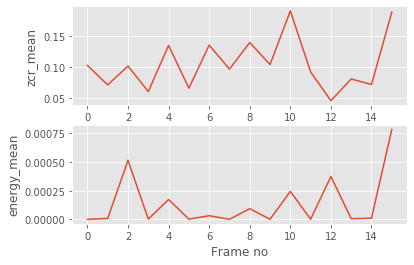

In [14]:
# MidTerm feature extraction example

obj = s3_connection.Object(bucket_name, key=path)
result = obj.get()['Body'].read()
wrapper = BytesIO(result)
wav_ = wavfile.read(wrapper)


Fs, x = wav_[0], wav_[1]
Mid_F, Short_F, mid_f_names = MidTermFeatures.mid_feature_extraction(signal=x,
                                                    sampling_rate=Fs, 
                                                    mid_window=0.5*Fs,
                                                    mid_step =Fs,
                                                    short_window = 0.050*Fs,
                                                    short_step = 0.025*Fs)
plt.subplot(2,1,1); plt.plot(Mid_F[0,:]); plt.xlabel('Frame no'); plt.ylabel(mid_f_names[0]) 
plt.subplot(2,1,2); plt.plot(Mid_F[1,:]); plt.xlabel('Frame no'); plt.ylabel(mid_f_names[1])


In [15]:
print(Mid_F)

[[1.03085299e-01 7.16197822e-02 1.02132486e-01 ... 8.11932849e-02
  7.22323049e-02 1.89110708e-01]
 [1.34936459e-06 8.46247093e-06 5.14937769e-04 ... 6.80571596e-06
  1.07695978e-05 7.83304933e-04]
 [2.86960318e+00 2.92535648e+00 2.72868707e+00 ... 2.74806708e+00
  2.81172940e+00 2.59975550e+00]
 ...
 [3.55884602e-02 3.20031793e-02 2.03151495e-02 ... 3.44371957e-02
  1.86855490e-02 2.63219073e-02]
 [6.83324532e-04 6.46347692e-04 5.46531808e-04 ... 2.30615041e-03
  1.07417672e-03 9.96458504e-04]
 [1.78212694e-02 2.76454492e-02 2.43232244e-02 ... 2.27474729e-02
  1.75553012e-02 8.76360573e-03]]


In [16]:
print(mid_f_names)

['zcr_mean', 'energy_mean', 'energy_entropy_mean', 'spectral_centroid_mean', 'spectral_spread_mean', 'spectral_entropy_mean', 'spectral_flux_mean', 'spectral_rolloff_mean', 'mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean', 'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean', 'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean', 'mfcc_13_mean', 'chroma_1_mean', 'chroma_2_mean', 'chroma_3_mean', 'chroma_4_mean', 'chroma_5_mean', 'chroma_6_mean', 'chroma_7_mean', 'chroma_8_mean', 'chroma_9_mean', 'chroma_10_mean', 'chroma_11_mean', 'chroma_12_mean', 'chroma_std_mean', 'delta zcr_mean', 'delta energy_mean', 'delta energy_entropy_mean', 'delta spectral_centroid_mean', 'delta spectral_spread_mean', 'delta spectral_entropy_mean', 'delta spectral_flux_mean', 'delta spectral_rolloff_mean', 'delta mfcc_1_mean', 'delta mfcc_2_mean', 'delta mfcc_3_mean', 'delta mfcc_4_mean', 'delta mfcc_5_mean', 'delta mfcc_6_mean', 'delta mfcc_7_mean', 'delta mfcc_8_mean', 'delta mfcc_9_

In [17]:
individual_df = pd.DataFrame(columns = mid_f_names, data = Mid_F.T)
individual_df.head()

,zcr_mean,energy_mean,energy_entropy_mean,spectral_centroid_mean,spectral_spread_mean,spectral_entropy_mean,spectral_flux_mean,spectral_rolloff_mean,mfcc_1_mean,mfcc_2_mean,...,delta chroma_4_std,delta chroma_5_std,delta chroma_6_std,delta chroma_7_std,delta chroma_8_std,delta chroma_9_std,delta chroma_10_std,delta chroma_11_std,delta chroma_12_std,delta chroma_std_std
0,0.103085,0.000001,2.869603,0.272477,0.274245,0.789995,0.004994,0.123911,-39.954295,1.497277,...,0.003674,0.045178,0.001152,0.103970,0.000285,0.000531,0.004874,0.035588,0.000683,0.017821
1,0.071620,0.000008,2.925356,0.257817,0.287874,0.362461,0.004179,0.040880,-36.913220,2.177397,...,0.004251,0.045136,0.001301,0.134642,0.000241,0.000864,0.006015,0.032003,0.000646,0.027645
2,0.102132,0.000515,2.728687,0.284287,0.256550,0.874902,0.004291,0.215245,-30.737055,1.605506,...,0.001819,0.017733,0.001310,0.101714,0.000448,0.000594,0.003039,0.020315,0.000547,0.024323
3,0.060844,0.000003,2.827166,0.250205,0.298276,0.236202,0.005663,0.015018,-37.660047,2.241594,...,0.002596,0.037854,0.003035,0.075778,0.000634,0.000877,0.003436,0.048096,0.000960,0.017154
4,0.135504,0.000174,2.614522,0.271537,0.239902,1.227320,0.002602,0.204356,-31.722767,1.194668,...,0.004184,0.014009,0.001490,0.064062,0.001233,0.001678,0.006150,0.023863,0.000709,0.013344


In [18]:
# Each row in F is a different feature for a signal. The columns are time "blocks"... normazlied
# f_names is a list of feature names
len(f_names)

68

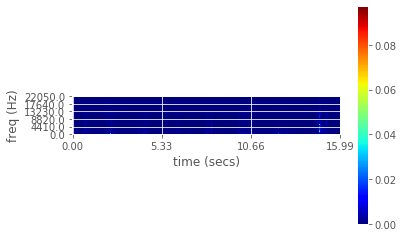

In [19]:
_ = ShortTermFeatures.spectrogram(x, Fs, window=200, step=1000, plot=True)

## Combining the work asbove into iterable functions

At a top level, iteratinging over the S3 bucket,
calling a function on each object that will create and store features into a database.
Need to include a file name as index or column, to allow a join later to labels csv

### see src.feature_extractions.py and clean_data.py

---



## Creating mel spectogram images of files. Account for different lengths. Also exporting sound data as numpy arrays format so no need to import .wav every time

A typical spectrogram uses a linear frequency scaling, so each frequency bin is spaced the equal number of Hertz apart. The mel-frequency scale on the other hand, is a quasi-logarithmic spacing roughly resembling the resolution of the human auditory system.

In [20]:
def read_audio(prep, data, trim_long_data):
    y, sr = librosa.load(data, sr=prep.sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > prep.samples: # long enough
        if trim_long_data:
            y = y[0:0+prep.samples]
    else: # pad blank
        padding = prep.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, prep.samples - len(y) - offset), 'reflect')
    return y

In [21]:
def audio_to_melspectrogram(prep, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=prep.sampling_rate,
                                                 n_mels=prep.n_mels,
                                                 hop_length=prep.hop_length,
                                                 n_fft=prep.n_fft,
                                                 fmin=prep.fmin,
                                                 fmax=prep.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

In [22]:
def show_melspectrogram(conf, mels, title='Log-frequency power spectrogram'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf.sampling_rate, hop_length=conf.hop_length,
                            fmin=conf.fmin, fmax=conf.fmax, cmap='gist_ncar')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)

In [23]:
def read_as_melspectrogram(prep, data, trim_long_data, debug_display=False):
    x = read_audio(prep, data, trim_long_data)
    mels = audio_to_melspectrogram(prep, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=prep.sampling_rate))
        show_melspectrogram(prep, mels)
    return mels, x

In [24]:
def convert_wav_to_image(df, s3_client, bucket_name, s3_folder, sample_size=5):
    X = {} # image accumulator
    flat = {} # flat accumulator
    audio_data = {} # audio accumulator
    for i, fname in enumerate(df.loc[:sample_size-1, 'fname']):
        data = call_s3(s3_client, bucket_name, fname, s3_folder)
        mels, aud = read_as_melspectrogram(prep, data, trim_long_data=True, debug_display=False)
        X[fname] = mels
        flat[fname] = mels.reshape(-1)
        audio_data[fname] = aud
        print(i, ' appended ',fname)
        
    flat_df = pd.DataFrame(flat).T.reset_index()
    flat_df['fname'] = flat_df['index']
    flat_df = pd.merge(df, flat_df, how='inner', on='fname').drop(['index'], 1)
    
    audio_df = pd.DataFrame(audio_data).T.reset_index()
    audio_df ['fname'] = audio_df['index']
    audio_df = pd.merge(df, audio_df, how= 'inner', on='fname').drop(['index'], 1)
    
    return X, flat_df, audio_df

In [25]:
class prep:
    # Preprocessing settings
    sampling_rate = 44100
    duration = 15 # seconds to trim down if long data
    hop_length = 347*duration # to make time steps 128
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration

In [26]:
df = pd.read_csv('data/train_labels.csv')
s3_client = boto3.client('s3')
bucket_name = 'jarednewstudy'
s3_folder = 'audio_train/'
path = '7e8cd849.wav'

In [27]:
X, flat, audio = convert_wav_to_image(df, s3_client, bucket_name, s3_folder, sample_size=3)

0  appended  ac9e7a91.wav
1  appended  65ae847e.wav
2  appended  32ec2454.wav


In [28]:
str(int(np.abs(audio[0][0] * 1000)))

'24'

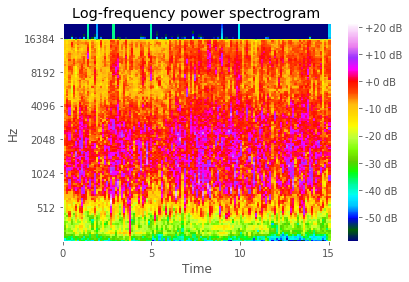

In [36]:
data = call_s3(s3_client, bucket_name, 'dc0479bc.wav', s3_folder)
x, _ = read_as_melspectrogram(prep, data, trim_long_data=True, debug_display=True)
# # # plt.savefig('img/purr.png', dpi=128, bbox_inches='tight')

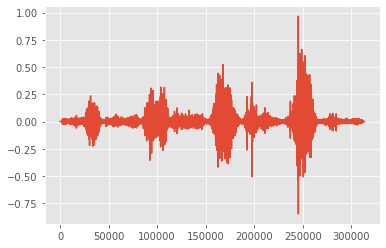

In [30]:
data = call_s3(s3_client, bucket_name, path, s3_folder)
sound, samplerate = sf.read(data)
plt.plot(sound)

In [31]:
for k, v in X.items():
    img = PIL.Image.fromarray(v, 'L')
    img.save('data/mel_images/{}.png'.format(k))

In [35]:
df.iloc[240]

fname                  dc0479bc.wav
labels          Trickle_and_dribble
freesound_id                 329061
license                       CC-BY
Name: 240, dtype: object